In [1]:
!pip install torchsummary
!pip install torchgeometry

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for torchgeometry from https://files.pythonhosted.org/packages/a6/d6/3f6820c0589bc3876080c59b58a3bad11af746a7b46f364b1cde7972bd72/torchgeometry-0.1.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 4.5 MB/s eta 0:00:00


In [2]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb

In [3]:
# !pip install ternausnet

In [4]:
# import ternausnet

In [5]:
# print(dir(ternausnet.models.models))

In [6]:
# from ternausnet.models import UNet16

In [7]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f577a38b-2421-0829-b22a-3213e658e5b1)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.0 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import segmentation_models_pytorch as smp

# model = smp.DeepLabV3Plus(
#     encoder_name="timm-regnetx_320",        
#     encoder_weights="imagenet",     
#     in_channels=3,                  
#     classes=3)
model = smp.DeepLabV3Plus(
    encoder_name="timm-regnetx_320",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_320-8ea38b93.pth" to /root/.cache/torch/hub/checkpoints/regnetx_320-8ea38b93.pth
100%|██████████| 412M/412M [00:20<00:00, 20.9MB/s]


# Parameters

In [11]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 10

# Hyperparameters for training 
learning_rate = 1e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

# Dataloader

In [12]:
transform = Compose([Resize((512,512), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

In [13]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label>0.65, 1.0, 0.0)
        
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [14]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

In [15]:
unet_dataset = UNetDataClass(images_path, masks_path, transform)

In [16]:
train_size = 0.9
valid_size = 0.1

In [17]:
torch.manual_seed(42)

In [18]:
train_set, valid_set = random_split(unet_dataset, 
                                    [int(train_size * len(unet_dataset)) , 
                                     int(valid_size * len(unet_dataset))])

In [19]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

# Data Augmentation

In [20]:
from albumentations import (
    Compose,
    RandomRotate90,
    Flip,
    Transpose,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomBrightnessContrast,
    HorizontalFlip,
    VerticalFlip,
    RandomGamma,
    RGBShift,
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
augmentation = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
])

In [22]:
class SegDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform=None, augmentation=None):
        super(SegDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        # Augmentation
        if self.augmentation:
            augmented = self.augmentation(image=np.array(data), mask=np.array(label))
            data = Image.fromarray(augmented['image'])
            label = Image.fromarray(augmented['mask'])
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label > 0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)


# transform = transforms.ToTensor()
aug_dataset = SegDataClass(images_path, masks_path, transform=transform, augmentation=augmentation)

In [23]:
torch.manual_seed(42)

In [24]:
train_aug_set, valid_aug_set = random_split(aug_dataset, 
                                    [int(train_size * len(aug_dataset)) , 
                                     int(valid_size * len(aug_dataset))])

In [25]:
from torch.utils.data import ConcatDataset
# combined_dataset = ConcatDataset([aug_dataset, train_set])
# train_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_aug_set, batch_size=batch_size, shuffle=True)

# Model

**Residual Block**

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)

        out += residual  
        out = self.relu(out)

        return out

**Encoder Block**

In [27]:
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

In [28]:
class res_encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(res_encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)
        
        
        x += residual  
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

**Decoder block**

In [29]:
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [30]:
class res_decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(res_decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        residual = self.conv1(residual)
        residual = self.bn3(residual)
        
        x += residual
        x = self.relu(x)
        
        return x

**Bottle neck**

In [31]:
class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

**Unet model**

In [32]:
# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = res_encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = ResidualBlock(512, 1024)
        
        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = res_decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        
        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        
        n5 = self.bottleneck(n4)
        
        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)
        
        output = self.out(n9)
        
        return output

# Loss function

In [33]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss
#         return dice_score

# Training

**Initialize weights**

In [34]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [35]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

**Train model**

In [36]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [37]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

In [38]:
# model = Unet(in_channels=3, num_classes = 3)

try:
    checkpoint = torch.load(pretrained_path)

    new_state_dict = OrderedDict()
    for k, v in checkpoint['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model)
    model.to(device)
except:
    model.apply(weights_init)
    model = nn.DataParallel(model)
    model.to(device)

In [39]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
try: 
    optimizer.load_state_dict(checkpoint['optimizer'])
except:
    pass

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [40]:
save_model(model, optimizer, checkpoint_path)

In [41]:
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key = 'cee1c832e904beaac5be683d72ce3d52c4503440',
)
wandb.init(
    project = "Unet_polyp-Segmentation"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: quockhoalma (l1234kl). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240307_041210-5t9n6zhn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run gentle-haze-9
wandb: ⭐️ View project at https://wandb.ai/l1234kl/Unet_polyp-Segmentation
wandb: 🚀 View run at https://wandb.ai/l1234kl/Unet_polyp-Segmentation/runs/5t9n6zhn


Start epoch #1, learning rate for this epoch: [0.0001]
Train Epoch: 1 [200/900 (22.22222222222222%)]	Loss: 1.6094
Train Epoch: 1 [400/900 (44.44444444444444%)]	Loss: 1.1693
Train Epoch: 1 [600/900 (66.66666666666667%)]	Loss: 1.3859
Train Epoch: 1 [800/900 (88.88888888888889%)]	Loss: 0.8889
Done epoch #1, time for this epoch: 344.443240404129s
Start epoch #2, learning rate for this epoch: [0.0001]
Train Epoch: 2 [200/900 (22.22222222222222%)]	Loss: 0.8148
Train Epoch: 2 [400/900 (44.44444444444444%)]	Loss: 0.9830
Train Epoch: 2 [600/900 (66.66666666666667%)]	Loss: 0.9010
Train Epoch: 2 [800/900 (88.88888888888889%)]	Loss: 1.0375
Done epoch #2, time for this epoch: 327.1439242362976s
Start epoch #3, learning rate for this epoch: [0.0001]
Train Epoch: 3 [200/900 (22.22222222222222%)]	Loss: 0.8454
Train Epoch: 3 [400/900 (44.44444444444444%)]	Loss: 1.0711
Train Epoch: 3 [600/900 (66.66666666666667%)]	Loss: 0.6938
Train Epoch: 3 [800/900 (88.88888888888889%)]	Loss: 0.8797
Done epoch #3, tim

In [42]:
# torch.cuda.empty_cache()

In [43]:
# save_model(model, optimizer, checkpoint_path)

In [44]:
# checkpoint = torch.load(pretrained_path)

In [45]:
# checkpoint = torch.load(checkpoint_path)

In [46]:
# for m in self.children():
#     m.cuda()
#     x = m(x)
#     m.cpu()
#     torch.cuda.empty_cache()

# Plot the learning cure

In [47]:
# load_model(model, checkpoint)

In [48]:
# plt.rcParams['figure.dpi'] = 90
# plt.rcParams['figure.figsize'] = (6, 4)
# epochs_array = range(epochs)

In [49]:
# # Plot Training and Test loss
# plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
# # plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
# plt.title('Training and Test loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

**Infer**

In [50]:
# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

In [51]:
# optimizer.load_state_dict(checkpoint['optimizer'])

In [52]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

**Visualize results**

In [53]:
# for i, (data, label) in enumerate(train_dataloader):
#     img = data
#     mask = label
#     break

In [54]:
# fig, arr = plt.subplots(4, 3, figsize=(16, 12))
# arr[0][0].set_title('Image')
# arr[0][1].set_title('Segmentation')
# arr[0][2].set_title('Predict')

# model.eval()
# with torch.no_grad():
#     predict = model(img)

# for i in range(4):
#     arr[i][0].imshow(img[i].permute(1, 2, 0));
    
#     arr[i][1].imshow(F.one_hot(mask[i]).float())
    
#     arr[i][2].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

**Create submission**

In [55]:
# transform = Compose([Resize((800, 1120), interpolation=InterpolationMode.BILINEAR),
#                      PILToTensor()])

In [56]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [57]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)

In [58]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

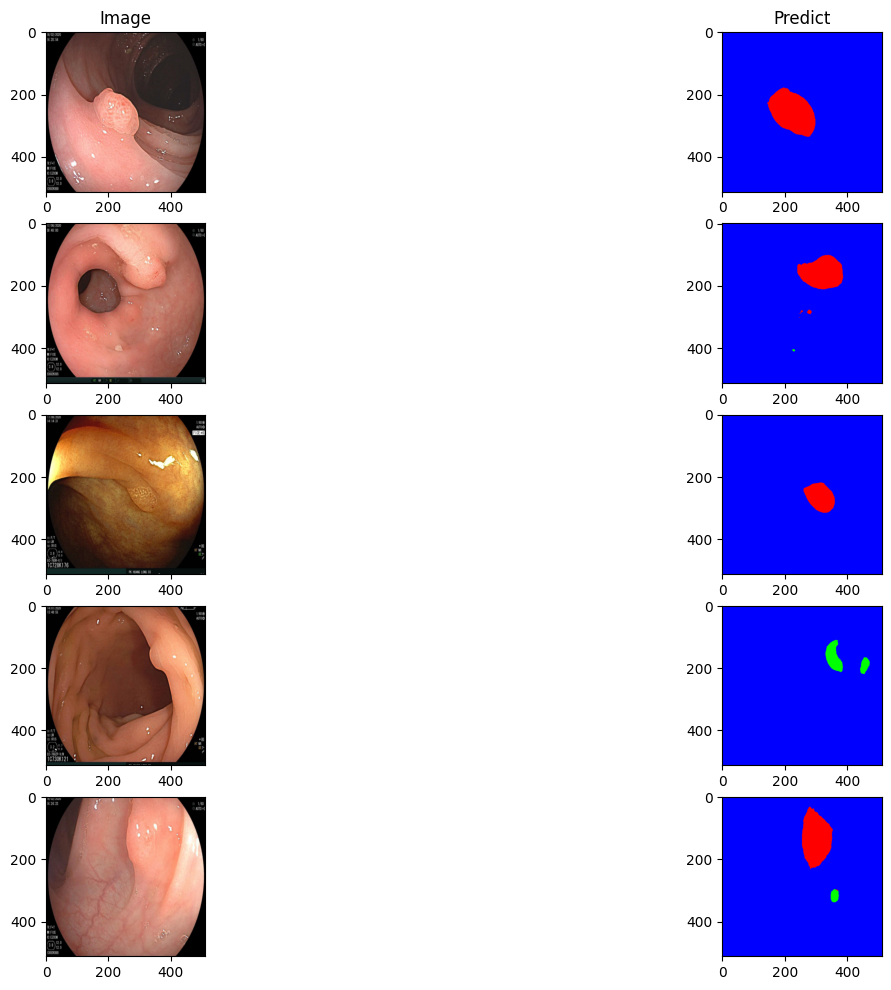

In [59]:
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [60]:
model.eval()
if not os.path.isdir("/kaggle/working/prediction"):
    os.mkdir("/kaggle/working/prediction")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/prediction/", filename))

In [61]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

/kaggle/working/prediction/780fd497e1c0e9082ea2c193ac8d551c.png
/kaggle/working/prediction/998906d3694abb47953b0e4909384b57.png
/kaggle/working/prediction/9632a3c6f7f7fb2a643f15bd0249ddcc.png
/kaggle/working/prediction/1002ec4a1fe748f3085f1ce88cbdf366.png
/kaggle/working/prediction/4f437f0019f7e6af7d7147763bdfb928.png
/kaggle/working/prediction/d6240619ebebe9e9c9d00a4262b4fe4a.png
/kaggle/working/prediction/626650908b1cb932a767bf5487ced51b.png
/kaggle/working/prediction/2a365b5574868eb60861ee1ff0b8a4f6.png
/kaggle/working/prediction/cdf3f33c3ca4d5060a633a8d5b2b2b55.png
/kaggle/working/prediction/a9d45c3dbc695325ded465efde988dfb.png
/kaggle/working/prediction/80cae6daedd989517cb8041ed86e5822.png
/kaggle/working/prediction/a48847ae8395e56a6d9ba9d45c3dbc69.png
/kaggle/working/prediction/fe1f119f21b248d152b672ab3492fc62.png
/kaggle/working/prediction/2ed9fbb63b28163a745959c03983064a.png
/kaggle/working/prediction/97e1c0e9082ea2c193ac8d551c149b60.png
/kaggle/working/prediction/dc0bb223c4eaf